<a href="https://colab.research.google.com/github/karthikpuranik11/Hope-Speech-Detection-/blob/main/Bert_base_uncased_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 9.6MB/s 
     |████████████████████████████████| 3.0MB 23.5MB/s 
     |████████████████████████████████| 1.1MB 52.8MB/s 
     |████████████████████████████████| 890kB 47.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=73977c3d97fbb78010cec045516bb2a901f5a5794febd7ba9a259f42a8eddc51
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [48]:
train1=pd.read_csv('/content/english_hope_dev.tsv', header=None, names=['tweets','label'], sep="\t")
train1['label'].value_counts()

Non_hope_speech    2569
Hope_speech         272
not-English           2
Name: label, dtype: int64

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('/content/english_hope_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,these tiktoks radiate gay chaotic energy and i...,1
1,@Champions Again He got killed for using false...,1
2,It's not that all lives don't matter,1
3,Is it really that difficult to understand? Bla...,1
4,Whenever we say black isn't that racists? Why...,1
...,...,...
22757,It's a load of bollocks every life matters sim...,1
22758,no say it because all lives matter! deku would...,1
22759,God says her life matters,1
22760,This video is just shit. A bunch of whiny ass ...,1


In [5]:
val=pd.read_csv('/content/english_hope_dev.tsv', header=None, names=['tweets','label'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

,tweets,labels
0,Thats it.... like....I dont like that statue,1
1,@Generation X Counting money that she been giv...,1
2,@Paola Hernandez i never said to be intolerant...,1
3,@Firstlast300 Wow An opinion is that I don't l...,1
4,WOW!!!!!!!That was so so inspiring and incredi...,0
...,...,...
2838,Such fake sentiment. .,1
2839,@A G black lives arent undervalued compared to...,1
2840,People who pulled it down can and will be arre...,1
2841,@Aaron Castellanos It will be a two hour movie...,1


In [6]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [7]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (22762, 2)
validation set size: (2843, 2)


In [9]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([  3.86714237,   0.36516187, 344.87878788])

In [13]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [14]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [15]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [16]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [17]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-uncased')
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [18]:
model = RFClassifier(3)
model = model.to(device)

In [19]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [20]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-uncased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 8m 2s
Train Loss 0.23057429075078892 accuracy 0.9201300412968983
Val Loss 0.17648530791231085 accuracy 0.9268378473443546

Epoch: 02 | Epoch Time: 8m 10s
Train Loss 0.14202784472328264 accuracy 0.9526403655214832
Val Loss 0.18634467529070176 accuracy 0.9338726697150896

Epoch: 03 | Epoch Time: 8m 10s
Train Loss 0.08623679059432045 accuracy 0.9752218609963975
Val Loss 0.24318934892293778 accuracy 0.9328174463594794

Epoch: 04 | Epoch Time: 8m 8s
Train Loss 0.05287700922920348 accuracy 0.9873473332747562
Val Loss 0.3225853611804084 accuracy 0.9285965529370384

Epoch: 05 | Epoch Time: 8m 8s
Train Loss 0.03740968639743933 accuracy 0.9917406203321325
Val Loss 0.358325781721852 accuracy 0.9257826239887442

Epoch: 06 | Epoch Time: 8m 8s
Train Loss 0.028721559568510385 accuracy 0.9933661365433618
Val Loss 0.3885157834333001 accuracy 0.9271895884628913

Epoch: 07 | Epoch Time: 8m 8s
Train Loss 0.022851052476847582 accuracy 0.9944205254371321
Val Loss 0.41950464345615496 

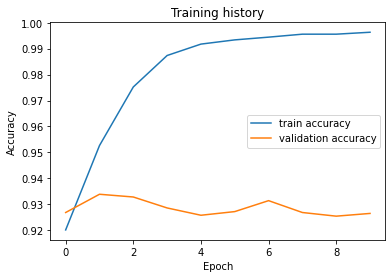

In [24]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [25]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.9264861062258177

In [26]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [30]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [52]:
class_name = ['Hope_speech','Non_hope_speech','not-English']

In [53]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                 precision    recall  f1-score   support

    Hope_speech       0.63      0.57      0.60       272
Non_hope_speech       0.95      0.96      0.96      2569
    not-English       0.00      0.00      0.00         2

       accuracy                           0.93      2843
      macro avg       0.53      0.51      0.52      2843
   weighted avg       0.92      0.93      0.92      2843



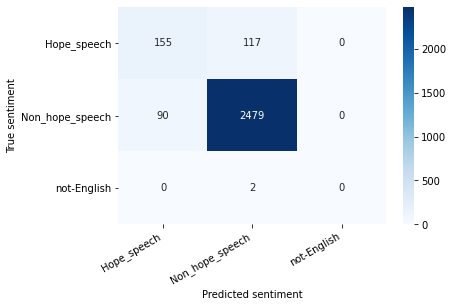

In [54]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [78]:
a={'id':[i for i in range(2843)]}
a=pd.DataFrame(a)



df=pd.DataFrame({'id': a.id, 'labels': y_pred})
df.labels = df.labels.apply({0:'Hope_speech', 1: 'non_hope_speech',2:'not-English'}.get)
df





,id,labels
0,0,non_hope_speech
1,1,non_hope_speech
2,2,non_hope_speech
3,3,non_hope_speech
4,4,non_hope_speech
...,...,...
2838,2838,non_hope_speech
2839,2839,non_hope_speech
2840,2840,non_hope_speech
2841,2841,non_hope_speech


In [81]:
df.to_csv('Bert_base_uncased_english_submission.csv',index=False)

In [83]:
from google.colab import files
files.download("Bert_base_uncased_english_submissionn.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>